# Лабораторная работа 1: «Метод обратного распространения ошибки»

## Цели работы
Цель - изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети (один скрытый слой).

## Задачи работы
Выполнение лабораторной работы предполагает решение следующих задач:
1. Изучить общую схему работы метода обратного распространения ошибки с использованием стохастического градиентного спуска.
2. Вывести математические формулы для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
3. Загрузить набор данных MNIST, выполнить предобработку изображений и меток, если это необходимо.
4. Реализовать и протестировать метод обратного распространения ошибки для задачи классификации рукописных цифр из набора данных MNIST.

## Формулы для обратного распространения ошибки
### Прямой проход
**Скрытый слой:**
$$f_s = \sum_{i=0}^{N} w_{si}^{(1)} x_i, \quad v_s = \varphi^{(1)}(f_s)$$

**Выходной слой:**
$$g_j = \sum_{s=0}^{K} w_{js}^{(2)} v_s, \quad u_j = \varphi^{(2)}(g_j)$$

### Функция ошибки (кросс-энтропия):
$$E(w) = -\frac{1}{L} \sum_{k=1}^{L} \sum_{j=1}^{M} y_j^k \ln u_j^k$$

### Обратный проход (градиенты):
#### 1. Градиенты для выходного слоя

**Локальный градиент:**
$$\delta_j^{(2)} = \frac{\partial E}{\partial g_j} = -(y_j - u_j)$$

**Градиенты по весам выходного слоя:**
$$\frac{\partial E}{\partial w_{js}^{(2)}} = \delta_j^{(2)} \cdot v_s = -(y_j - u_j) \cdot v_s$$

#### 2. Градиенты для скрытого слоя

**Локальный градиент:**
$$\delta_s^{(1)} = \frac{\partial E}{\partial f_s} = \sum_{j=1}^{M} \delta_j^{(2)} \cdot w_{js}^{(2)} \cdot \frac{d\varphi^{(1)}(f_s)}{df_s}$$

**Градиенты по весам скрытого слоя:**
$$\frac{\partial E}{\partial w_{si}^{(1)}} = \delta_s^{(1)} \cdot x_i = \left( \sum_{j=1}^{M} \delta_j^{(2)} \cdot w_{js}^{(2)} \cdot \frac{d\varphi^{(1)}(f_s)}{df_s} \right) \cdot x_i$$

### Обновление весов (стохастический градиентный спуск):
**Для выходного слоя:**
$$w_{js}^{(2)}(k+1) = w_{js}^{(2)}(k) - \eta \cdot \frac{\partial E}{\partial w_{js}^{(2)}}$$

**Для скрытого слоя:**
$$w_{si}^{(1)}(k+1) = w_{si}^{(1)}(k) - \eta \cdot \frac{\partial E}{\partial w_{si}^{(1)}}$$

### Обозначения

- $x_i$ - входные сигналы ($i = 1, N$, где $N = 28 \times 28 = 784$)
- $w_{si}^{(1)}$ - веса скрытого слоя ($s = 1, K$, где $K = 300$)
- $w_{js}^{(2)}$ - веса выходного слоя ($j = 1, M$, где $M = 10$)
- $v_s$ - выходы скрытого слоя
- $u_j$ - выходы выходного слоя
- $\varphi^{(1)}$ - функция активации скрытого слоя (ReLU)
- $\varphi^{(2)}$ - функция активации выходного слоя (softmax)
- $\eta$ - скорость обучения
- $\delta_j^{(2)}$, $\delta_s^{(1)}$ - локальные градиенты (сигналы ошибки)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
"""Загрузка изображений"""
def load_images(filename):
    with open(filename, 'rb') as f:
        f.read(16)  # Пропускаем заголовок
        images = np.fromfile(f, dtype=np.uint8)
        images = images.reshape(-1, 28, 28)
        images = images.astype(np.float32) / 255.0
    return images

"""Загрузка меток"""
def load_labels(filename):
    with open(filename, 'rb') as f:
        f.read(8)  # Пропускаем заголовок
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Загрузка данных
train_images = load_images('mnist/train-images-idx3-ubyte')
train_labels = load_labels('mnist/train-labels-idx1-ubyte')
test_images = load_images('mnist/t10k-images-idx3-ubyte')
test_labels = load_labels('mnist/t10k-labels-idx1-ubyte')

print("Данные загружены:")
print(f"Тренировочные: images {train_images.shape}, labels {train_labels.shape}")
print(f"Тестовые: images {test_images.shape}, labels {test_labels.shape}")

Данные загружены:
Тренировочные: images (60000, 28, 28), labels (60000,)
Тестовые: images (10000, 28, 28), labels (10000,)


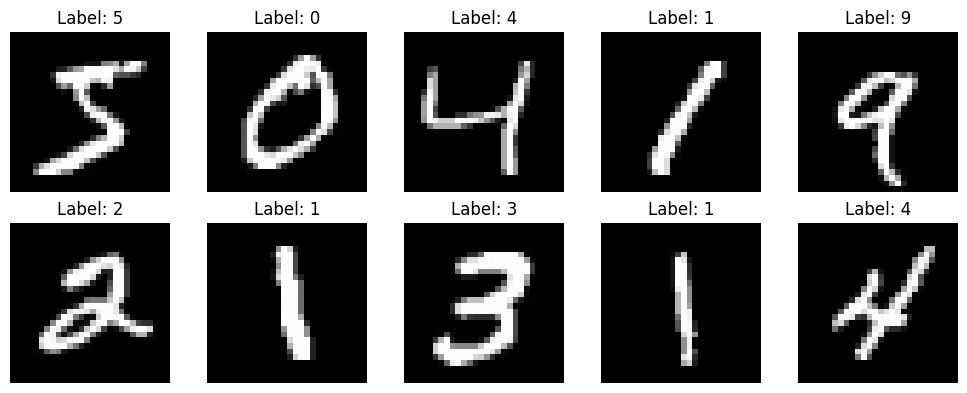

In [10]:
# Визуализация примеров
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f'Label: {train_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Реализация функций активации и функции ошибки
- Функция активации скрытого слоя: ReLU
- Функция активации выходного слоя: softmax
- Функция ошибки: кросс-энтропия

In [11]:
"""Функция активации ReLU"""
def relu(x):
    return np.maximum(0, x)

"""Производная функции ReLU"""
def relu_derivative(x):
    return (x > 0).astype(np.float32)

"""Функция активации softmax"""
def softmax(x):
    # Вычитаем максимум для избежания переполнения
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

"""Функция ошибки кросс-энтропии"""
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    # Только вероятности для правильных классов
    log_likelihood = -np.log(y_pred[np.arange(m), np.argmax(y_true, axis=1)] + 1e-8)
    return np.sum(log_likelihood) / m

## Реализация метода обратного распространения ошибки

In [12]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.N = input_size    # N - количество входных нейронов
        self.K = hidden_size   # K - количество нейронов скрытого слоя  
        self.M = output_size   # M - количество нейронов выходного слоя
        self.η = learning_rate # η - скорость обучения
        
        # Инициализация весов
        self.w_si = np.random.randn(self.N, self.K) * np.sqrt(2.0 / self.N)
        self.b_s = np.zeros((1, self.K))
        
        self.w_js = np.random.randn(self.K, self.M) * np.sqrt(2.0 / self.K)
        self.b_j = np.zeros((1, self.M))
        
    """Прямой проход через сеть"""
    def forward(self, X):

        self.f_s = np.dot(X, self.w_si) + self.b_s
        self.v_s = relu(self.f_s)
        
        self.g_j = np.dot(self.v_s, self.w_js) + self.b_j
        self.u_j = softmax(self.g_j)
        
        return self.u_j
    
    """Обратный проход (вычисление градиентов и обновление весов)"""
    def backward(self, X, y_true, u_j):

        m = X.shape[0]
        
        δ_j = u_j.copy()
        δ_j[np.arange(m), np.argmax(y_true, axis=1)] -= 1
        δ_j /= m
        
        d_w_js = np.dot(self.v_s.T, δ_j)
        d_b_j = np.sum(δ_j, axis=0, keepdims=True)
        
        δ_s_before_activation = np.dot(δ_j, self.w_js.T)
        δ_s = δ_s_before_activation * relu_derivative(self.f_s)
        
        d_w_si = np.dot(X.T, δ_s)
        d_b_s = np.sum(δ_s, axis=0, keepdims=True)
        
        self.w_js -= self.η * d_w_js
        self.b_j -= self.η * d_b_j
        self.w_si -= self.η * d_w_si
        self.b_s -= self.η * d_b_s
    
    """Предсказание классов для входных данных"""
    def predict(self, X):
        u_j = self.forward(X)
        return np.argmax(u_j, axis=1)
    
    """Вычисление точности классификации"""
    def accuracy(self, X, y_true):
        predictions = self.predict(X)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)
    
    """Перемешивание данных"""
    def shuffle_data(self, X, y):
        indices = np.random.permutation(X.shape[0])
        return X[indices], y[indices]
    
    """Обучение"""
    def train(self, X_train, y_train, epochs, batch_size):
        print("Начало обучения:")
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # Перемешиваем данные
            X_shuffled, y_shuffled = self.shuffle_data(X_train, y_train)
            
            # Обучение по батчам
            for i in range(0, len(X_train), batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                
                # Прямой проход + обратный проход
                u_j_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, u_j_pred)
            
            # Вычисление метрик после эпохи
            accuracy = self.accuracy(X_train, y_train)
            loss = cross_entropy_loss(y_train, self.forward(X_train))
            epoch_time = time.time() - start_time
            
            print(f"Эпоха {epoch+1:2d} | "
                  f"Время: {epoch_time:5.2f}с | "
                  f"Ошибка: {loss:.4f} | "
                  f"Точность: {accuracy:.4f}")
    
    def test(self, X_test, y_test):
        """Тестирование нейронной сети"""
        accuracy = self.accuracy(X_test, y_test)
        loss = cross_entropy_loss(y_test, self.forward(X_test))
        
        print(f"\nРезультаты на тесте:")
        print(f"Точность: {accuracy:.4f}")
        print(f"Ошибка: {loss:.4f}")
        
        return accuracy, loss

## Конфигурация нейронной сети и параметры обучения
- Входной слой: 28х28
- Скрытый слой: 300
- Выходной слой: 10
- Скорость обучения: 0.1
- Размер пачки данных: 32
- Количество эпох: 20

In [13]:
# Параметры сети
N = 28 * 28
K = 300 
M = 10
η = 0.1
batch_size = 32
epochs = 20

# Подготовка данных
X_train = train_images.reshape(-1, N)
X_test = test_images.reshape(-1, N)

# One-hot encoding меток
train_labels_onehot = np.eye(M)[train_labels]
test_labels_onehot = np.eye(M)[test_labels]

# Создание и обучение модели
model = NeuralNetwork(N, K, M, η)
model.train(X_train, train_labels_onehot, epochs, batch_size)

Начало обучения:
Эпоха  1 | Время:  3.32с | Ошибка: 0.1567 | Точность: 0.9554
Эпоха  2 | Время:  2.88с | Ошибка: 0.0991 | Точность: 0.9727
Эпоха  3 | Время:  2.86с | Ошибка: 0.0743 | Точность: 0.9801
Эпоха  4 | Время:  2.89с | Ошибка: 0.0563 | Точность: 0.9852
Эпоха  5 | Время:  2.94с | Ошибка: 0.0509 | Точность: 0.9855
Эпоха  6 | Время:  2.96с | Ошибка: 0.0382 | Точность: 0.9899
Эпоха  7 | Время:  2.95с | Ошибка: 0.0306 | Точность: 0.9931
Эпоха  8 | Время:  2.94с | Ошибка: 0.0260 | Точность: 0.9940
Эпоха  9 | Время:  2.91с | Ошибка: 0.0279 | Точность: 0.9933
Эпоха 10 | Время:  2.91с | Ошибка: 0.0183 | Точность: 0.9968
Эпоха 11 | Время:  2.89с | Ошибка: 0.0173 | Точность: 0.9965
Эпоха 12 | Время:  2.90с | Ошибка: 0.0127 | Точность: 0.9983
Эпоха 13 | Время:  2.99с | Ошибка: 0.0133 | Точность: 0.9982
Эпоха 14 | Время:  2.90с | Ошибка: 0.0096 | Точность: 0.9991
Эпоха 15 | Время:  2.93с | Ошибка: 0.0135 | Точность: 0.9970
Эпоха 16 | Время:  3.01с | Ошибка: 0.0068 | Точность: 0.9997
Эпоха 1

In [14]:
# Тестирование модели
test_accuracy, test_loss = model.test(X_test, test_labels_onehot)


Результаты на тесте:
Точность: 0.9811
Ошибка: 0.0611


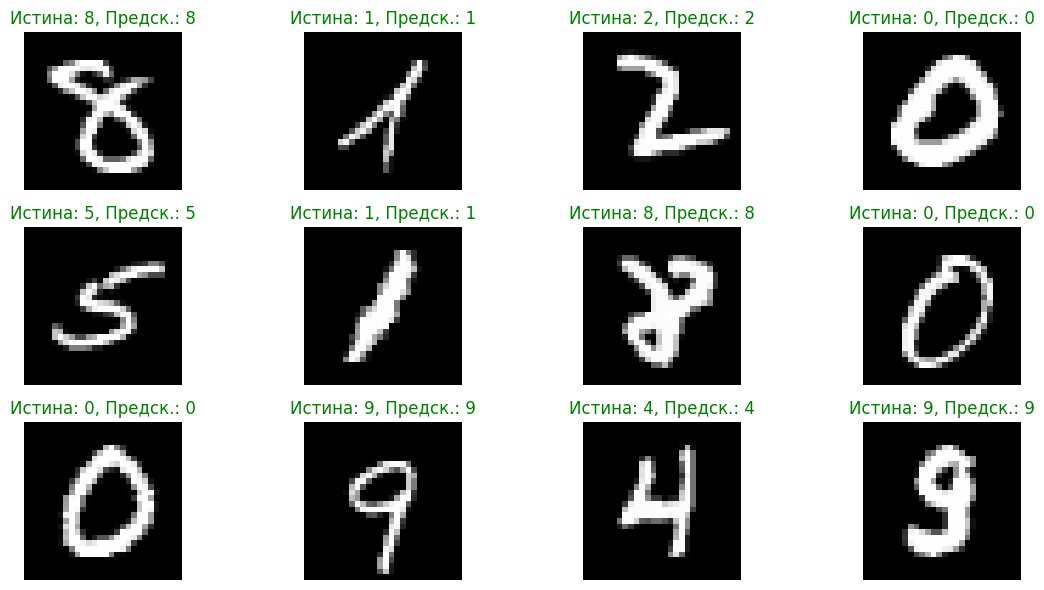

In [15]:
# Демонстрация предсказаний
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    idx = np.random.randint(0, len(X_test))
    
    image = X_test[idx].reshape(28, 28)
    true_label = test_labels[idx]
    prediction = model.predict(X_test[idx:idx+1])[0]
    
    plt.imshow(image, cmap='gray')
    color = 'green' if true_label == prediction else 'red'
    plt.title(f'Истина: {true_label}, Предск.: {prediction}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()